# [Trilemma Foundation](https://www.trilemma.foundation/) x [Strategy](https://www.strategy.com/) Stacking Sats Tournament

**Hosted on [Hypertrial.ai](https://www.hypertrial.ai/bitcoin-arena/challenge/bitcoin)**

### Model Development Template

---

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hypertrial/stacking_sats_challenge/blob/main/tutorials/4.%20Strategy%20Development%20Template.ipynb)

A youtube walkthrough of an older (less general) version of this notebook can useful to watch:

[![YouTube](https://img.shields.io/badge/Watch%20on-YouTube-red?logo=youtube&logoColor=white)](https://youtu.be/qJp8W83f3Fw?si=Wzo8ORKwFLHhBoM0)

This notebook replicates the structure used by the evaluation engine to test all submitted strategies.

---

## ✅ What You’ll Learn

By the end of this tutorial, you will:

- Understand the **boilerplate code** and what is already provided (e.g. imports, data loading, global config)
- Learn where and how to **insert your own strategy logic**
- Run **backtests and visualizations** to debug and assess performance
- Ensure your submission is **valid, testable, and reproducible**

---

## 🛠️ What You’re Expected to Do

- **Modify only the user code** inside the provided cell  
- Leave all boilerplate (e.g. registration, config, data loading) unchanged
- Submit your user code cell for evaluation on [Hypertrial.ai]('https://www.hypertrial.ai/')

This structure guarantees consistency, fairness, and ease of comparison across all submitted models.

---

> ⚠️ Do not change function names, decorators, or global config values unless explicitly allowed.  
> Your entry must adhere to this template to be considered valid.


# Model Development Template

### 🚫 Boilerplate Code — Do Not Modify

In [4]:
# 🚫 DO NOT MODIFY: Framework boilerplate cell
# ---------------------------
# core/config.py
# ---------------------------

# ╔═════════════════════╗
# ║  Global Variables   ║
# ╚═════════════════════╝


# Back-test date range
BACKTEST_START     = '2011-06-01'
BACKTEST_END       = '2025-06-01'

# Rolling window length (in months)
INVESTMENT_WINDOW  = 12

# Step frequency for window start-dates: 'Daily', 'Weekly' or 'Monthly'
PURCHASE_FREQ      = 'Daily'

# Minimum per-period weight (to avoid zero allocations)
MIN_WEIGHT         = 1e-5


PURCHASE_FREQ_TO_OFFSET = {
    'Daily':   '1D',
    'Weekly':  '7D',
    'Monthly': '1M',
}

In [5]:
# 🚫 DO NOT MODIFY: Framework boilerplate cell
# ---------------------------
# Extract BTC data from CoinMetrics and save locally
# ---------------------------
import logging
from io import StringIO  # new import

import pandas as pd
import requests  # new import

try:
    from coinmetrics.api_client import CoinMetricsClient
except ImportError:
    raise ImportError("coinmetrics.api_client module is required. Install it via pip:\n\n    pip install coinmetrics-api-client")

# Configure logging
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

def extract_btc_data_to_csv(local_path='btc_data.csv'):
    # Coin Metrics BTC CSV (raw GitHub URL)
    url = "https://raw.githubusercontent.com/coinmetrics/data/master/csv/btc.csv"

    # Download the content
    response = requests.get(url)
    response.raise_for_status()  # raises an error for bad responses

    # Parse CSV content
    btc_df = pd.read_csv(StringIO(response.text))

    btc_df['time'] = pd.to_datetime(btc_df['time']).dt.normalize()
    btc_df['time'] = btc_df['time'].dt.tz_localize(None)
    btc_df.set_index('time', inplace=True)

    btc_df.to_csv(local_path)

    # Show the df
    btc_df

btc_df = extract_btc_data_to_csv("btc_data.csv")

/var/folders/zn/3r5r5myd1dq34m6jv1g5rq7m0000gn/T/ipykernel_2053/4179518580.py:32: DtypeWarning: Columns (147) have mixed types. Specify dtype option on import or set low_memory=False.
  btc_df = pd.read_csv(StringIO(response.text))


In [6]:
# 🚫 DO NOT MODIFY: Framework boilerplate cell
# ---------------------------
# core/data.py
# ---------------------------
import logging

import numpy as np

logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

def load_data():
    df = pd.read_csv("btc_data.csv", index_col=0, parse_dates=True)
    df = df.loc[~df.index.duplicated(keep='last')]
    df = df.sort_index()
    return df

def validate_price_data(df):
    if df.empty or 'PriceUSD' not in df.columns:
        raise ValueError("Invalid BTC price data.")
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Index must be datetime.")

# Global Variable to use later
df = load_data()

/var/folders/zn/3r5r5myd1dq34m6jv1g5rq7m0000gn/T/ipykernel_2053/2700240794.py:16: DtypeWarning: Columns (147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("btc_data.csv", index_col=0, parse_dates=True)


In [7]:

# ╔════════════════════════════════════════════════════════╗
# ║  Helper: human‐readable rolling‐window labels           ║
# ╚════════════════════════════════════════════════════════╝
def _make_window_label(window_start: pd.Timestamp, window_end: pd.Timestamp) -> str:
    """
    Format "YYYY-MM-DD → YYYY-MM-DD" for a rolling window.
    """
    start_str = pd.to_datetime(window_start).strftime("%Y-%m-%d")
    end_str   = pd.to_datetime(window_end).strftime("%Y-%m-%d")
    return f"{start_str} → {end_str}"

# ╔════════════════════════════════════════════════════════╗
# ║  Rolling‐window SPD computation                         ║
# ╚════════════════════════════════════════════════════════╝
def compute_cycle_spd(
    dataframe: pd.DataFrame,
    strategy_function
) -> pd.DataFrame:
    """
    Compute sats‐per‐dollar (SPD) stats over rolling windows.

    - Uses full‐history features (no look‐ahead).
    - Window length = INVESTMENT_WINDOW months.
    - Step every PURCHASE_FREQ.
    - Returns a DataFrame indexed by window label, with:
        min_sats_per_dollar, max_sats_per_dollar,
        uniform_sats_per_dollar, dynamic_sats_per_dollar,
        uniform_percentile, dynamic_percentile, excess_percentile.
    """
    # 1) Precompute full-history features & restrict to backtest
    full_feat = construct_features(dataframe).loc[BACKTEST_START:BACKTEST_END]

    # 2) Window parameters
    window_offset  = pd.DateOffset(months=INVESTMENT_WINDOW)
    step_freq      = PURCHASE_FREQ_TO_OFFSET[PURCHASE_FREQ]

    results = []
    for window_start in pd.date_range(
        start=pd.to_datetime(BACKTEST_START),
        end=pd.to_datetime(BACKTEST_END) - window_offset,
        freq=step_freq
    ):
        window_end  = window_start + window_offset
        feat_slice  = full_feat.loc[window_start:window_end]
        price_slice = dataframe["PriceUSD"].loc[window_start:window_end]

        if price_slice.empty:
            continue

        label       = _make_window_label(window_start, window_end)
        inv_price   = (1.0 / price_slice) * 1e8  # sats per dollar

        # Compute weights on this slice
        weight_slice = strategy_function(feat_slice)

        # Uniform vs. dynamic SPD
        uniform_spd = inv_price.mean()
        dynamic_spd = (weight_slice * inv_price).sum()

        # Min/max for percentile scaling
        min_spd = inv_price.min()   # low price → high SPD
        max_spd = inv_price.max()   # high price → low SPD
        span    = max_spd - min_spd

        uniform_pct = (uniform_spd - min_spd) / span * 100
        dynamic_pct = (dynamic_spd - min_spd) / span * 100

        results.append({
            "window":                   label,
            "min_sats_per_dollar":      min_spd,
            "max_sats_per_dollar":      max_spd,
            "uniform_sats_per_dollar":  uniform_spd,
            "dynamic_sats_per_dollar":  dynamic_spd,
            "uniform_percentile":       uniform_pct,
            "dynamic_percentile":       dynamic_pct,
            "excess_percentile":        dynamic_pct - uniform_pct,
        })

    return pd.DataFrame(results).set_index("window")


# ╔════════════════════════════════════════════════════════╗
# ║  Backtest wrapper: aggregate + print SPD metrics       ║
# ╚════════════════════════════════════════════════════════╝
def backtest_dynamic_dca(
    dataframe: pd.DataFrame,
    strategy_function,
    *,
    strategy_label: str = "strategy"
) -> pd.DataFrame:
    """
    1) Runs compute_cycle_spd(...)
    2) Prints aggregated min/max/mean/median of dynamic SPD
    3) Prints aggregated SPD percentiles
    4) Computes & prints exponentially-decayed average SPD and percentile
    5) Returns the full SPD table.

    Exponential decay:
      • decay_rate ∈ (0,1): lower → faster decay
      • most recent window has highest weight
      • weights normalized to sum to 1
    """
    # --- run the rolling-window SPD backtest
    spd_table   = compute_cycle_spd(dataframe, strategy_function)
    dynamic_spd = spd_table["dynamic_sats_per_dollar"]
    dynamic_pct = spd_table["dynamic_percentile"]

    # --- print standard aggregated metrics
    print(f"\nAggregated Metrics for {strategy_label}:")
    print("Dynamic Sats-per-Dollar:")
    for stat in ("min", "max", "mean", "median"):
        val = getattr(dynamic_spd, stat)()
        print(f"  {stat}: {val:.2f}")

    print("\nDynamic SPD Percentiles:")
    for stat in ("min", "max", "mean", "median"):
        val = getattr(dynamic_pct, stat)()
        print(f"  {stat}: {val:.2f}%")

    # --- exponential decay weighting
    decay_rate = 0.9
    N = len(dynamic_spd)
    # weight for window i (0 = oldest, N-1 = newest)
    raw_weights = np.array([decay_rate ** (N - 1 - i) for i in range(N)])
    exp_weights = raw_weights / raw_weights.sum()

    # --- compute decayed averages
    exp_avg_spd = (dynamic_spd.values * exp_weights).sum()
    exp_avg_pct = (dynamic_pct.values * exp_weights).sum()

    # --- print decayed metrics
    print(f"\nExponential-Decay Average SPD: {exp_avg_spd:.2f}")
    print(f"Exponential-Decay Average SPD Percentile: {exp_avg_pct:.2f}%")

    return spd_table

# ╔════════════════════════════════════════════════════════╗
# ║  Submission checker: forward‐leakage + weight & perf   ║
# ╚════════════════════════════════════════════════════════╝
def check_strategy_submission_ready(
    dataframe: pd.DataFrame,
    strategy_function
) -> None:
    """
    Sanity-check that `strategy_function`:
      1. Uses no future data (forward-leakage test).
      2. Produces weights ≥ MIN_WEIGHT.
      3. Sums to 1.0 in each rolling window.
      4. Outperforms uniform DCA in at least 50% of rolling windows.
    """
    passed = True

    # ──────────────────────────────────────────────────────────
    # 1) Forward-leakage test
    # ──────────────────────────────────────────────────────────
    backtest_df  = dataframe.loc[BACKTEST_START:BACKTEST_END]
    full_weights = strategy_function(dataframe) \
                       .reindex(backtest_df.index) \
                       .fillna(0.0)

    step_dates = max(len(backtest_df) // 50, 1)
    probe_dates = backtest_df.index[::step_dates]

    for probe in probe_dates:
        masked = dataframe.copy()
        masked.loc[masked.index > probe, :] = np.nan

        masked_wt = strategy_function(masked) \
                        .reindex(full_weights.index) \
                        .fillna(0.0)

        if not np.isclose(masked_wt.loc[probe],
                          full_weights.loc[probe],
                          rtol=1e-9, atol=1e-12):
            delta = abs(masked_wt.loc[probe] - full_weights.loc[probe])
            print(f"[{probe.date()}] ❌ Forward-leakage detected (Δ={delta:.2e})")
            passed = False
            break

    # ──────────────────────────────────────────────────────────
    # 2) Weight checks per rolling window
    # ──────────────────────────────────────────────────────────
    window_offset = pd.DateOffset(months=INVESTMENT_WINDOW)
    step_freq     = PURCHASE_FREQ_TO_OFFSET[PURCHASE_FREQ]

    for window_start in pd.date_range(
        start=pd.to_datetime(BACKTEST_START),
        end=pd.to_datetime(BACKTEST_END) - window_offset,
        freq=step_freq
    ):
        window_end = window_start + window_offset
        label      = _make_window_label(window_start, window_end)

        w_slice = strategy_function(dataframe.loc[window_start:window_end])

        if (w_slice <= 0).any():
            print(f"[{label}] ❌ Non-positive weights detected.")
            passed = False

        if (w_slice < MIN_WEIGHT).any():
            print(f"[{label}] ❌ Weight below MIN_WEIGHT = {MIN_WEIGHT}.")
            passed = False

        total = w_slice.sum()
        if not np.isclose(total, 1.0, rtol=1e-5, atol=1e-8):
            print(f"[{label}] ❌ Sum-to-1 check failed: {total:.4f}")
            passed = False

    # ──────────────────────────────────────────────────────────
    # 3) Performance vs. Uniform DCA (RELAXED)
    # ──────────────────────────────────────────────────────────
    spd_table = compute_cycle_spd(dataframe, strategy_function)

    underperf_records = []
    for label, row in spd_table.iterrows():
        dp, up = row["dynamic_percentile"], row["uniform_percentile"]
        if dp < up:
            underperf_records.append({
                "Window": label,
                "Dynamic Percentile": dp,
                "Uniform Percentile": up,
                "Delta": dp - up
            })

    total = len(spd_table)
    failed = len(underperf_records)
    pass_ratio = (total - failed) / total

    if underperf_records:
        df_underperf = pd.DataFrame(underperf_records)
        print("\n⚠️ Windows where strategy underperformed Uniform DCA:")
        display(df_underperf)

    print(f"\nSummary: Your strategy underperformed uniform DCA in {failed} out of {total} windows "
          f"({100 * pass_ratio:.2f}% win rate)")

    if pass_ratio >= 0.5:
        print("✅ Strategy meets performance requirement (≥ 50% win rate vs. uniform DCA).")
    else:
        print("❌ Strategy failed performance requirement (< 50% win rate vs. uniform DCA).")
        passed = False

    # ──────────────────────────────────────────────────────────
    # Final verdict
    # ──────────────────────────────────────────────────────────
    if passed:
        print("\n✅ Strategy is ready for submission.")
    else:
        print("\n⚠️ Please address the above issues before submitting.")

In [8]:
# ---------------------------
# core/plots.py
# ---------------------------
import matplotlib.pyplot as plt
import pandas as pd

#from core.config import (
 #   BACKTEST_START,
  #  BACKTEST_END,
   # INVESTMENT_WINDOW,
    #PURCHASE_FREQ,
    #MIN_WEIGHT,
    #PURCHASE_FREQ_TO_OFFSET,
#)
#from core.spd import _make_window_label


def _get_window_index(timestamp: pd.Timestamp) -> int:
    """
    Map a timestamp to its 0-based rolling-window index,
    where windows start every PURCHASE_FREQ and span INVESTMENT_WINDOW months.
    """
    window_offset = pd.DateOffset(months=INVESTMENT_WINDOW)
    step          = PURCHASE_FREQ_TO_OFFSET[PURCHASE_FREQ]
    valid_starts  = pd.date_range(
        start=pd.to_datetime(BACKTEST_START),
        end=pd.to_datetime(BACKTEST_END) - window_offset,
        freq=step
    )
    # get the position of the last valid start ≤ timestamp
    idx = valid_starts.get_indexer([timestamp], method='pad')[0]
    return int(idx)


def plot_features(
    df: pd.DataFrame,
    weights: pd.Series | None = None,
    *,
    start_date: str | pd.Timestamp = BACKTEST_START,
    end_date:   str | pd.Timestamp = BACKTEST_END,
) -> None:
    """
    Plot BTC price vs. the first derived feature within the chosen back-test window.
    """
    df_feat = construct_features(df).loc[start_date:end_date]

    if weights is not None:
        weights = weights.loc[df_feat.index]

    feature_name = df_feat.columns[1]

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.set_title(f"BTC Price and {feature_name}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Value")

    ax.plot(df_feat.index, df_feat["PriceUSD"], label="BTC Price", color="black", alpha=0.7)
    ax.plot(df_feat.index, df_feat[feature_name], label=feature_name, color="orange", alpha=0.7)

    signal = df_feat["PriceUSD"] < df_feat[feature_name]
    ax.fill_between(
        df_feat.index,
        df_feat["PriceUSD"],
        df_feat[feature_name],
        where=signal,
        color="green",
        alpha=0.1,
    )

    if weights is not None:
        ax.scatter(
            df_feat.index[~signal],
            df_feat.loc[~signal, "PriceUSD"],
            marker="o",
            facecolors="none",
            edgecolors="blue",
            label="Uniform",
        )
        ax.scatter(
            df_feat.index[signal],
            df_feat.loc[signal, "PriceUSD"],
            marker="o",
            color="red",
            label="Dynamic",
        )

    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()


def plot_final_weights_by_window(
    dataframe: pd.DataFrame,
    strategy_fn,
    *,
    window_stride: int = 1
):
    """
    For each rolling window, run strategy_fn on that slice,
    and plot the resulting weights curve (subsampled by window_stride).
    """
    window_length = pd.DateOffset(months=INVESTMENT_WINDOW)
    step          = PURCHASE_FREQ_TO_OFFSET[PURCHASE_FREQ]
    starts        = pd.date_range(
        start=pd.to_datetime(BACKTEST_START),
        end=pd.to_datetime(BACKTEST_END) - window_length,
        freq=step
    )

    fig, ax = plt.subplots(figsize=(12,5))
    cmap = plt.get_cmap("tab10")

    for idx, ws in enumerate(starts):
        if idx % window_stride != 0:
            continue

        we      = ws + window_length
        df_win  = dataframe.loc[ws:we]
        w_win   = strategy_fn(df_win)           # sums to 1 by design
        label   = f"{ws.date()} → {we.date()}"
        color   = cmap(idx % 10)

        ax.plot(w_win.index, w_win.values, label=label, color=color)
        ax.hlines(1.0/len(w_win), w_win.index[0], w_win.index[-1],
                  color=color, linestyle='--', alpha=0.5)

    ax.axhline(MIN_WEIGHT, color='black', linestyle='--', label=f"MIN_WEIGHT={MIN_WEIGHT}")
    ax.set_title("Weights by Rolling Window")
    ax.set_xlabel("Date")
    ax.set_ylabel("Weight")
    ax.legend(fontsize='small', ncol=2, loc='upper center')
    ax.grid(True)
    plt.tight_layout()
    plt.show()

#######

def plot_rolling_window_weight_sums(
    dataframe: pd.DataFrame,
    strategy_fn,
) -> None:
    """
    Re-run the strategy on each rolling window, and plot each window’s total weight
    (should be ~1.0).
    """
    window_offset = pd.DateOffset(months=INVESTMENT_WINDOW)
    step          = PURCHASE_FREQ_TO_OFFSET[PURCHASE_FREQ]

    starts = pd.date_range(
        start=pd.to_datetime(BACKTEST_START),
        end=pd.to_datetime(BACKTEST_END) - window_offset,
        freq=step
    )

    sums = []
    for ws in starts:
        we         = ws + window_offset
        df_window  = dataframe.loc[ws:we]
        w          = strategy_fn(df_window)
        sums.append(w.sum())

    plt.figure(figsize=(12, 5))
    plt.plot(starts, sums, marker="o", linestyle="-")
    plt.axhline(1.0, color="black", linestyle="--", label="Target = 1.0")
    plt.title("Per-Window Strategy Weight Sums (should be 1.0)")
    plt.xlabel("Window Start Date")
    plt.ylabel("Sum of Weights")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_spd_comparison(
    spd_results: pd.DataFrame,
    strategy_name: str = "Dynamic",
    *,
    window_stride: int = 1
) -> None:
    """
    Compare uniform vs dynamic DCA in sats-per-dollar and percentile space,
    subsampling every `window_stride`-th rolling window.
    """
    subs = spd_results.iloc[::window_stride]
    x    = np.arange(len(subs))

    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.set_yscale("log")

    # Plot each line separately so we can assign colours
    l_max, = ax1.plot(x, subs["max_sats_per_dollar"],     "o-", color="green")
    l_dyn, = ax1.plot(x, subs["dynamic_sats_per_dollar"], "o-", color="blue")
    l_uni, = ax1.plot(x, subs["uniform_sats_per_dollar"], "o-", color="orange")
    l_min, = ax1.plot(x, subs["min_sats_per_dollar"],     "o-", color="red")

    ax1.set_title(f"Uniform vs {strategy_name} DCA (SPD)")
    ax1.set_ylabel("Sats per Dollar (log scale)")
    ax1.set_xlabel("Window")
    ax1.grid(True, linestyle="--", linewidth=0.5)
    ax1.set_xticks(x)
    ax1.set_xticklabels(subs.index, rotation=45, ha="right")
    ax1.legend(
        [l_max, l_dyn, l_uni, l_min],
        ["Max SPD", strategy_name, "Uniform SPD", "Min SPD"],
        loc="upper left",
    )

    # Twin axis for percentiles
    ax2 = ax1.twinx()
    bw   = 0.4
    ubar = ax2.bar(x - bw/2, subs["uniform_percentile"],  width=bw, alpha=0.3, color='orange')
    dbar = ax2.bar(x + bw/2, subs["dynamic_percentile"], width=bw, alpha=0.3, color='blue')
    ax2.set_ylabel("SPD Percentile (%)")
    ax2.set_ylim(0, 100)
    ax2.legend([ubar, dbar], ["Uniform %", f"{strategy_name} %"], loc="upper right")

    plt.tight_layout()
    plt.show()

# ✍️ User Code — Implement Your Strategy Logic Below

In [10]:
import pandas as pd

#from typing import Any
#from core.config import BACKTEST_START, BACKTEST_END, INVESTMENT_WINDOW, PURCHASE_FREQ, MIN_WEIGHT
#from core.plots  import _get_window_index
#from core.strategies import register_strategy  # if you use strategy registration

# ╔══════════════════════════════════════╗
# ║  ADD Additional Imports under here:  ║
# ╚══════════════════════════════════════╝

def construct_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Construct technical indicators used for the strategy.
    Uses only past data for calculations to avoid look-ahead bias.
    """
    df = df.copy()
    df = df[['PriceUSD']]
    past_price = df['PriceUSD'].shift(1)
    df['ma200'] = past_price.rolling(window=200, min_periods=1).mean()
    df['std200'] = past_price.rolling(window=200, min_periods=1).std()
    return df

# Example Ethereum wallet address - replace with real one for actual submissions
# ETH_WALLET_ADDRESS = "0x71C7656EC7ab88b098defB751B7401B5f6d8976F"

# @register_strategy(ETH_WALLET_ADDRESS)

def compute_weights(df_window: pd.DataFrame) -> pd.Series:
    """
    Given a 12-month slice, compute portfolio weights that sum to 1.
    Whenever a day’s weight is ‘boosted’, redistribute the excess uniformly
    over the last half of the window (i.e. the final ~6 months).
    """
    # 1. Build feature DataFrame and index info
    features = construct_features(df_window)
    dates = features.index
    total_days = len(features)

    # 2. Prepare output Series
    weights = pd.Series(index=dates, dtype=float)

    # 3. Strategy parameters
    #    PURCHASE_FREQ is one of 'Daily', 'Weekly', or 'Monthly'
    # half of the window in rows = half of total_days
    rebalance_window = max(total_days // 2, 1)
    boost_alpha      = 1.25

    # 4. Initialize equal weights
    base_weight  = 1.0 / total_days
    temp_weights = np.full(total_days, base_weight)

    # 5. Extract numpy arrays for speed
    price_array  = features["PriceUSD"].values
    ma200_array  = features["ma200"].values
    std200_array = features["std200"].values

    # 6. Loop through each day
    for day_idx in range(total_days):
        price = price_array[day_idx]
        ma200 = ma200_array[day_idx]
        std200 = std200_array[day_idx]

        # skip if no valid signal
        if pd.isna(ma200) or pd.isna(std200) or std200 == 0 or price >= ma200:
            continue

        # compute how far below MA200
        z_score = (ma200 - price) / std200

        # boost this day’s weight
        boosted_weight = temp_weights[day_idx] * (1 + boost_alpha * z_score)
        excess = boosted_weight - temp_weights[day_idx]

        # redistribute excess over the last half of the window
        start_redistribution = max(total_days - rebalance_window, day_idx + 1)
        redistribution_indices = np.arange(start_redistribution, total_days)
        if redistribution_indices.size == 0:
            continue  # nothing to drain from

        per_day_reduction = excess / redistribution_indices.size

        # apply only if no one falls below MIN_WEIGHT
        if np.all(temp_weights[redistribution_indices] - per_day_reduction >= MIN_WEIGHT):
            temp_weights[day_idx] = boosted_weight
            temp_weights[redistribution_indices] -= per_day_reduction
        # else: skip this boost but continue looping

    # 7. Assign back into a pandas Series and return
    weights.loc[dates] = temp_weights
    return weights

### 🚫 Boilerplate Code — Do Not Modify

/var/folders/zn/3r5r5myd1dq34m6jv1g5rq7m0000gn/T/ipykernel_2053/2700240794.py:16: DtypeWarning: Columns (147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("btc_data.csv", index_col=0, parse_dates=True)


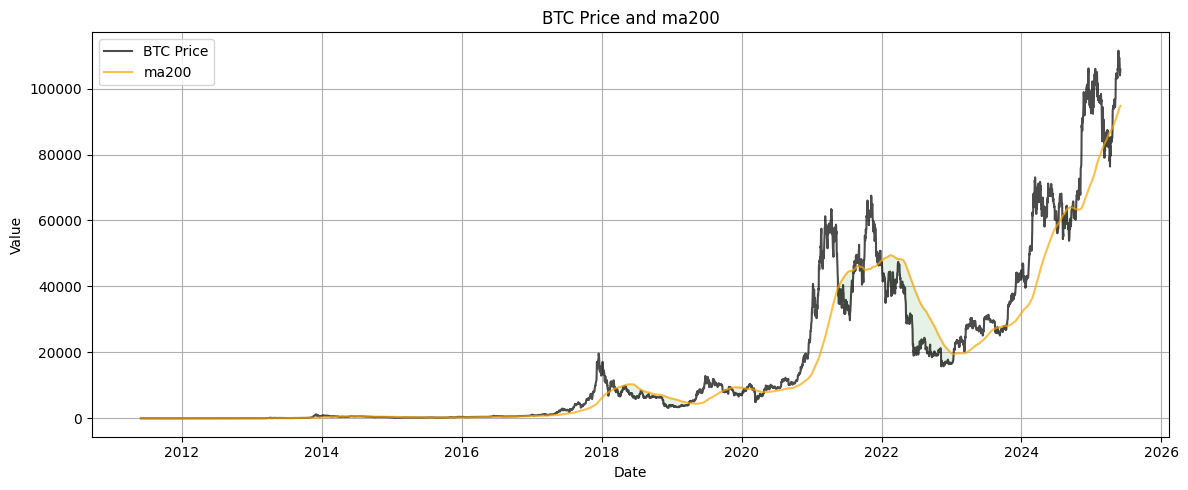

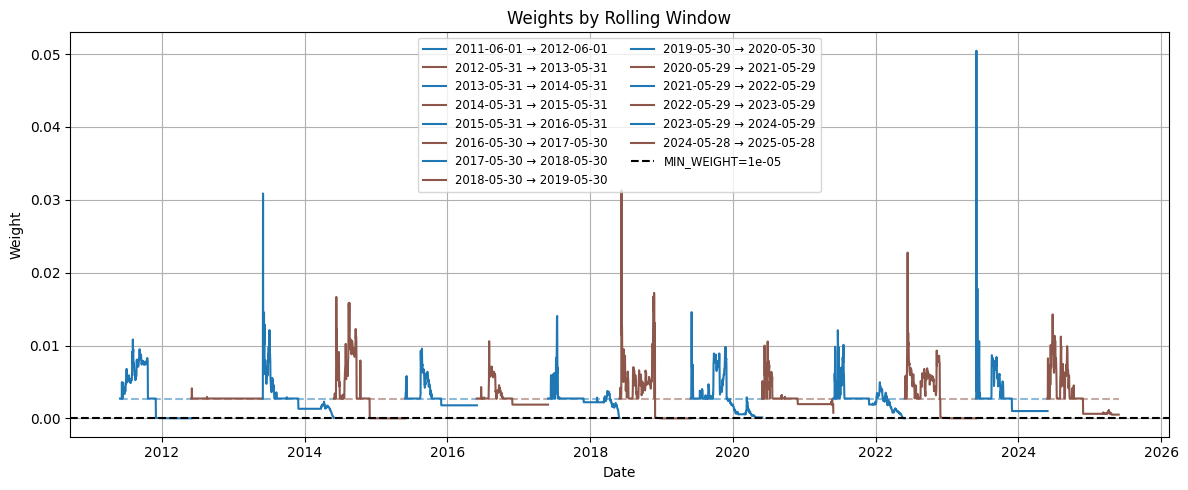

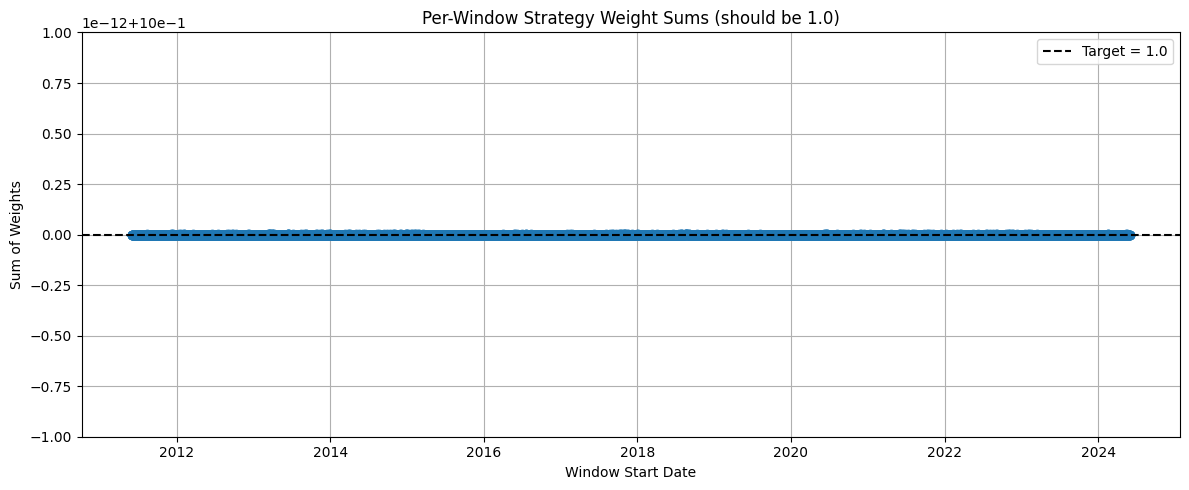


Aggregated Metrics for 200-Day MA DCA:
Dynamic Sats-per-Dollar:
  min: 1515.73
  max: 32202795.20
  mean: 1635813.96
  median: 19188.64

Dynamic SPD Percentiles:
  min: 9.79%
  max: 87.22%
  mean: 42.21%
  median: 42.32%

Exponential-Decay Average SPD: 1546.28
Exponential-Decay Average SPD Percentile: 67.17%


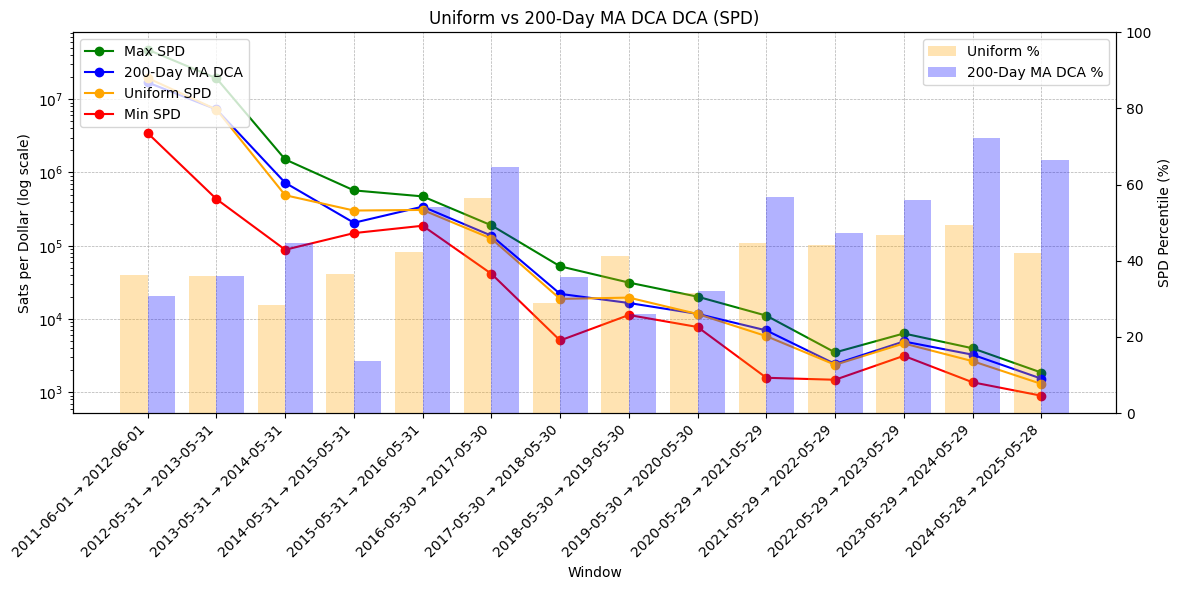


⚠️ Windows where strategy underperformed Uniform DCA:


,Window,Dynamic Percentile,Uniform Percentile,Delta
0,2011-06-01 → 2012-06-01,30.614254,36.333692,-5.719438
1,2011-06-02 → 2012-06-02,29.343263,36.387371,-7.044107
2,2011-06-03 → 2012-06-03,28.259231,36.448228,-8.188997
3,2011-06-04 → 2012-06-04,28.057807,36.522474,-8.464667
4,2011-06-05 → 2012-06-05,28.332490,36.602678,-8.270189
...,...,...,...,...
1129,2022-05-04 → 2023-05-04,52.494032,54.537543,-2.043511
1130,2022-05-05 → 2023-05-05,48.923801,51.867349,-2.943549
1131,2022-05-06 → 2023-05-06,49.274681,51.452267,-2.177586
1132,2022-05-07 → 2023-05-07,50.156180,50.932445,-0.776266



Summary: Your strategy underperformed uniform DCA in 1134 out of 4750 windows (76.13% win rate)
✅ Strategy meets performance requirement (≥ 50% win rate vs. uniform DCA).

✅ Strategy is ready for submission.
CPU times: user 23.7 s, sys: 133 ms, total: 23.8 s
Wall time: 23.9 s


In [12]:
%%time

btc_df = load_data()
validate_price_data(btc_df)
btc_df = btc_df.loc[BACKTEST_START:BACKTEST_END]

# 1) Feature plot (no weights):
plot_features(btc_df)

# 2) Final weights curves—computed per window:
plot_final_weights_by_window(
    btc_df,
    compute_weights,
    window_stride=365
)

# 3) Per-window weight-sum check:
plot_rolling_window_weight_sums(
    btc_df,
    compute_weights
)

# 4) Rolling-window SPD backtest:
df_spd = backtest_dynamic_dca(
    btc_df,
    compute_weights,
    strategy_label="200-Day MA DCA"
)

# 5) SPD comparison (subsampled by window_stride):
plot_spd_comparison(
    df_spd,
    strategy_name="200-Day MA DCA",
    window_stride=365
)

# 6) Sanity checks (each window inside):
check_strategy_submission_ready(btc_df, compute_weights)

In [13]:
win_rate = 76.13  # insert your win rate (%)
exp_decay_percentile = 67.17  # insert your exp-decay avg SPD percentile (%)

score = 0.5 * win_rate + 0.5 * exp_decay_percentile
print(f"Final Model Score (50/50 weighting): {score:.2f}%")

Final Model Score (50/50 weighting): 71.65%
